# <font color = 'pickle'>**Import/Install the packages**

In [ ]:
if 'google.colab' in str(get_ipython()):
    print('Running on Colab')
else:
    print('Not Running on Colab')

Not Running on Colab


In [ ]:
if 'google.colab' in str(get_ipython()):
  !pip install --upgrade feature_engine scikit-learn -q

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
import feature_engine

In [ ]:
print(feature_engine.__version__)

1.3.0


In [ ]:
import sklearn

In [ ]:
print(sklearn.__version__)

1.1.1


In [ ]:
"""Importing the required packages"""

# For DataFrames and manipulations
import pandas as pd
import numpy as np

# For data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

from scipy.stats import uniform, truncnorm, randint, loguniform

# drop arbitrary features
from feature_engine.selection import DropFeatures
# For categorical variables
from feature_engine.encoding import OneHotEncoder
# Missing value imputation
from feature_engine.imputation import MeanMedianImputer
# add missing indicator 
from feature_engine.imputation import AddMissingIndicator
# categorical imputer
from feature_engine.imputation import CategoricalImputer
# random sample imputer
from feature_engine.imputation import RandomSampleImputer
# feature engine wrapper 
from feature_engine.wrappers import SklearnTransformerWrapper


# For splitting the dataset
from sklearn.model_selection import train_test_split

# Using Support Vector Machines as models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# creating pipelines 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Hyper parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

# draws a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# save and load models
import joblib

# Pathlib to navigate file system
from pathlib import Path
import sys

# <font color = 'pickle'> **Specify Project Folder Location**

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive') 

In [ ]:
if 'google.colab' in str(get_ipython()):
    base_folder = Path('/content/drive/MyDrive/data/')
else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor/data/')

In [ ]:
data_folder = base_folder/'datasets'
save_model_folder = base_folder/'models/ml_fall_2022'
custom_function_folder = base_folder/'custom-functions'
save_model_folder.mkdir(exist_ok=True, parents=True)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
sys.path.append(str(custom_function_folder))

In [ ]:
sys.path

['/home/harpreet/Insync/google_drive_teaching/teaching_fall_2022/ml-fall-2022/Lecture10_DT_Ensemble_Imbalance_Code',
 '/home/harpreet/mambaforge/lib/python39.zip',
 '/home/harpreet/mambaforge/lib/python3.9',
 '/home/harpreet/mambaforge/lib/python3.9/lib-dynload',
 '',
 '/home/harpreet/mambaforge/lib/python3.9/site-packages',
 '/home/harpreet/Insync/google_drive_shaannoor/data/custom-functions']

In [ ]:
from  plot_learning_curve import plot_learning_curve

In [ ]:
from eda_plots import diagnostic_plots, plot_target_by_category

# <font color = 'pickle'>**Import the dataset**
Next, we will create variables to store paths where the data exists and where we will save the model. 

Now, we will create a variable to store the specific data file path from the data source folder.

In [ ]:
file = data_folder / 'modified_churn.csv'

Now, we will create a data-frame using the above file path and Pandas....  

In [ ]:
df = pd.read_csv(file)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4074 entries, 0 to 4073
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       4074 non-null   int64  
 1   RowNumber        4074 non-null   int64  
 2   CustomerId       4074 non-null   int64  
 3   Surname          4074 non-null   object 
 4   CreditScore      4074 non-null   int64  
 5   Geography        3585 non-null   object 
 6   Gender           4033 non-null   object 
 7   Age              3543 non-null   float64
 8   Tenure           4072 non-null   float64
 9   Balance          4067 non-null   float64
 10  NumOfProducts    4070 non-null   float64
 11  HasCrCard        4074 non-null   int64  
 12  IsActiveMember   4074 non-null   int64  
 13  EstimatedSalary  4074 non-null   float64
 14  Exited           4074 non-null   int64  
dtypes: float64(5), int64(7), object(3)
memory usage: 477.5+ KB


# <font color = 'pickle'>**Split Data into Train/Test set**

In [ ]:
# before doing any data cleaning step we need to first split the data into train/test
X = df.drop(['Exited'], axis =1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=0, stratify =y)

In [ ]:
# before doing any data cleaning step we need to first split the data into train/test
X = df.drop(['Exited'], axis =1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify =y)

# <font color = 'pickle'>**Complete Pipeline**

We will need to modify the pre-processing steps we have been using. 
- Trees really don't care about the scale and distribution of the data. 
- Hence we will not need to do descertization of balance and credit variables. 
- Futher , we do not need to do log transformatiomn of Age. 
- Tree based models are not affected by outliers as well. So we do not need to do the winsorizer step. 
- So basically, we need to do missing value imputations followed by encoding of categorical varibles.

**NOTE :Some tree based models can also work with missing values. Futher they can take categorical variables directly without one hot encoding. However, these implementations are not yet availible im sklearn. Hence we will need to do missing value imputation follwed by one hot encoding of categorical variables.**


In [ ]:
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname','Unnamed: 0']

churn_pipeline_preprocess = Pipeline([
                           
    ('drop_features',
      DropFeatures(columns_to_drop)),

    ('imputer_median',
      MeanMedianImputer(imputation_method='median', variables=['Age', 'Balance', 'NumOfProducts'])),

    ('imputer_catgorical_frequent',
      CategoricalImputer(imputation_method = 'frequent', variables=['Gender','Geography'])),

      ('imputer_missing_indicator',
      AddMissingIndicator(variables=['Age', 'Geography'])),

    ('imputer_random_sample',
      RandomSampleImputer(random_state=123, variables=['Tenure'])),
    
    ('one_hot_encoder',
      OneHotEncoder(variables=['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
                   , drop_last= True, ignore_format=True)),   

])

In [ ]:
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname','Unnamed: 0']

churn_pipeline_rf = Pipeline([
                           
    ('drop_features',
      DropFeatures(columns_to_drop)),

    ('imputer_median',
      MeanMedianImputer(imputation_method='median', variables=['Age', 'Balance', 'NumOfProducts'])),

    ('imputer_catgorical_frequent',
      CategoricalImputer(imputation_method = 'frequent', variables=['Gender','Geography'])),

      ('imputer_missing_indicator',
      AddMissingIndicator(variables=['Age', 'Geography'])),

    ('imputer_random_sample',
      RandomSampleImputer(random_state=123, variables=['Tenure'])),
    
    ('one_hot_encoder',
      OneHotEncoder(variables=['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
                   , drop_last= True, ignore_format=True)),   
    
    ('rf', RandomForestClassifier(oob_score=True, random_state= 0))

])

In [ ]:
from sklearn import set_config

set_config(display='diagram')
churn_pipeline_preprocess


Pipeline(steps=[('drop_features',
                 DropFeatures(features_to_drop=['RowNumber', 'CustomerId',
                                                'Surname', 'Unnamed: 0'])),
                ('imputer_median',
                 MeanMedianImputer(variables=['Age', 'Balance',
                                              'NumOfProducts'])),
                ('imputer_catgorical_frequent',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['Gender', 'Geography'])),
                ('imputer_missing_indicator',
                 AddMissingIndicator(variables=['Age', 'Geography'])),
                ('imputer_random_sample',
                 RandomSampleImputer(random_state=123, variables=['Tenure'])),
                ('one_hot_encoder',
                 OneHotEncoder(drop_last=True, ignore_format=True,
                               variables=['Geography', 'Gender', 'HasCrCard',
                                          'IsActiveMember']))])

## <font color = 'pickle'>**Find number of estimators**

For RandomForest the two important hypaerparameters other than decision tree hyperparameters are :

  1. n_estimators - number of estimators <br>
  2.  max_features

  - We should first fine tune n_estimators and then tune other hyperparameters. 
  
  - It is not a good idea to use gridsearch to tune number of estimators because the higher value will be typically better. But there are diminishing returns. 
  
  - Further if you try different values e.g. 50, 100, 150, you do not want to estimate 300 trees. You should add trees             iteratively and stop whenever you think that adding more tres is not helpful.

  - In scikit-learn, you use Warm-Starts to achieve this. When Warm Start = True, once you estimate model for n_estimators = 50, it would not start from scratch when estimating model for n_estimator = 100. 
  
  - Further you can use out of bag (oob) estimates instead of using cross validation to find number of estimators

In [ ]:
# Preprocessing - Train data
X_train_processed = churn_pipeline_preprocess.fit_transform(X_train)

In [ ]:
train_scores = []
oob_scores = []
best_oob_score = 0
best_n_estimators = 50

rf = RandomForestClassifier(warm_start=True, random_state=0, oob_score=True)
estimator_range = range(50, 500, 10)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train_processed, y_train)
    train_scores.append(rf.score(X_train_processed, y_train))
    oob_scores.append(rf.oob_score_)
    if rf.oob_score_ > best_oob_score:
        best_n_estimators = n_estimators
        best_oob_score = rf.oob_score_         


In [ ]:
print(best_n_estimators)

240


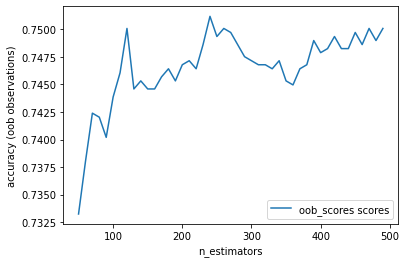

In [ ]:
plt.plot(estimator_range, oob_scores, label="oob_scores scores")
plt.ylabel("accuracy (oob observations)")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

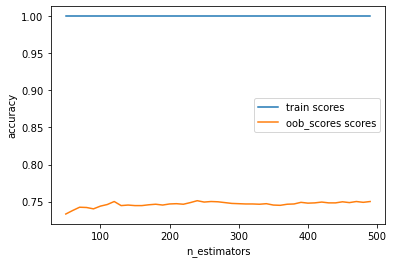

In [ ]:
plt.plot(estimator_range, train_scores, label="train scores")
plt.plot(estimator_range, oob_scores, label="oob_scores scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

## <font color = 'pickle'>**Hyperparameter Tuning - Round 1** 

### <font color = 'pickle'>**Specify Param Grid**

In [ ]:
# now we create the grid with all the parameters that we would like to test.

param_grid_1= {
    'rf__n_estimators' :[240],
    'rf__max_features' : ["sqrt", "log2",None],
    'rf__max_depth': np.arange(2,10),
    'rf__min_samples_leaf': np.arange(2,20),
    'rf__max_leaf_nodes': np.arange(2, 20),
    'rf__min_impurity_decrease': loguniform(0.00001, 0.1),
    }

   
     
# now we set up the grid search with cross-validation
grid_rf_1 = RandomizedSearchCV(churn_pipeline_rf, param_grid_1,
                           cv=5, return_train_score= True, n_jobs=-1, n_iter=500)

### <font color = 'pickle'>**Fit Model**

In [ ]:
# fit the model
grid_rf_1.fit(X_train,y_train)  

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('drop_features',
                                              DropFeatures(features_to_drop=['RowNumber',
                                                                             'CustomerId',
                                                                             'Surname',
                                                                             'Unnamed: '
                                                                             '0'])),
                                             ('imputer_median',
                                              MeanMedianImputer(variables=['Age',
                                                                           'Balance',
                                                                           'NumOfProducts'])),
                                             ('imputer_catgorical_frequent',
                                              CategoricalImputer(imputation_method='frequent',
                                                                 variables=['Gender',
                                                                            'Geography'])),
                                             ('im...
                   param_distributions={'rf__max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'rf__max_features': ['sqrt', 'log2',
                                                             None],
                                        'rf__max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'rf__min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc433404df0>,
                                        'rf__min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'rf__n_estimators': [240]},
                   return_train_score=True)

### <font color = 'pickle'>**Get Best Params**

In [ ]:
grid_rf_1.best_params_

{'rf__max_depth': 5,
 'rf__max_features': 'log2',
 'rf__max_leaf_nodes': 16,
 'rf__min_impurity_decrease': 0.00012202504883637589,
 'rf__min_samples_leaf': 4,
 'rf__n_estimators': 240}

### <font color = 'pickle'>**Save Model**

In [ ]:
file_best_estimator_round1 = save_model_folder / 'rf_round1_best_estimator.pk'
file_complete_grid_round1 = save_model_folder / 'rf_round1_complete_grid.pkl'

In [ ]:
joblib.dump(grid_rf_1.best_estimator_, file_best_estimator_round1)
joblib.dump(grid_rf_1, file_complete_grid_round1)

['/home/harpreet/Insync/google_drive_shaannoor/data/models/ml_fall_2022/rf_round1_complete_grid.pkl']

### <font color = 'pickle'>**Load Saved Model**

In [ ]:
loaded_best_estimator_round1 = joblib.load(file_best_estimator_round1)
loaded_complete_grid_round1 = joblib.load(file_complete_grid_round1)

### <font color = 'pickle'>**Plot Learning Curve**

<module 'matplotlib.pyplot' from '/home/harpreet/mambaforge/lib/python3.9/site-packages/matplotlib/pyplot.py'>

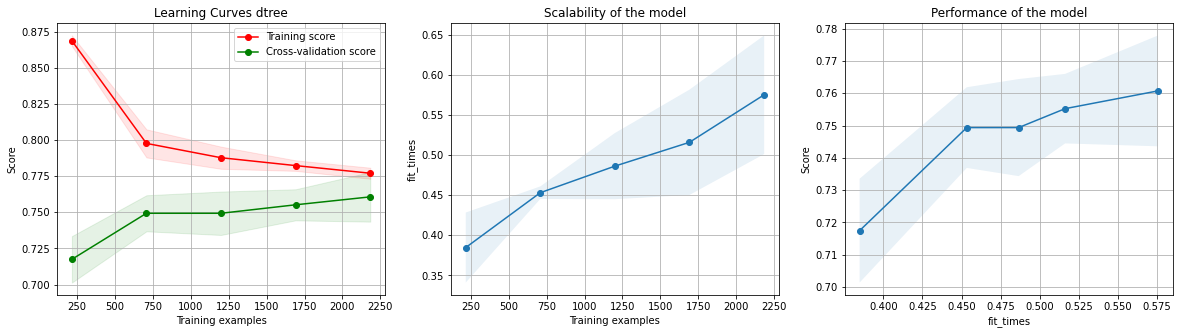

In [ ]:
plot_learning_curve(loaded_best_estimator_round1, 
                    'Learning Curves dtree',
                    X_train, y_train, n_jobs=-1)

### <font color = 'pickle'>**Check Cross Validation Score and Train Score**

In [ ]:
#let's check the train scores
print(loaded_best_estimator_round1.score(X_train,y_train))

#let's check the cross validation score
print(loaded_complete_grid_round1.best_score_)

0.7739098570905093
0.7607285680680176


### <font color = 'pickle'>**Check RandomSearchCV results**

In [ ]:
# we also find the data for all models evaluated

results = pd.DataFrame(loaded_complete_grid_round1.cv_results_)
results.head()
# sort the results by mean_test_score
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results[[
    'param_rf__max_features',
    'param_rf__max_depth',
    'param_rf__min_samples_leaf',
    'param_rf__max_leaf_nodes',
    'param_rf__min_impurity_decrease',
    
    'mean_test_score', 'std_test_score', 'mean_train_score'
]].head(20)

,param_rf__max_features,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__max_leaf_nodes,param_rf__min_impurity_decrease,mean_test_score,std_test_score,mean_train_score
0,log2,5,4,16,0.000122,0.760729,0.017155,0.777575
1,log2,9,13,18,0.00055,0.760363,0.017020,0.782888
2,sqrt,5,12,17,0.000058,0.760361,0.016563,0.777117
3,log2,5,16,15,0.00018,0.759629,0.016952,0.775010
4,log2,5,14,14,0.000017,0.759628,0.018402,0.774185
5,log2,8,14,16,0.000478,0.759264,0.018241,0.779956
6,log2,6,17,12,0.000031,0.759264,0.017490,0.772262
7,log2,8,13,15,0.000051,0.759264,0.018019,0.777391
8,sqrt,8,16,19,0.000117,0.759263,0.017876,0.782888
9,sqrt,5,13,18,0.000025,0.759263,0.018284,0.778216


**From the above results, we can see that max_depth = 5** 

## Hyperparameter Tuning - Round 2
In this round, we will try to fine tune, max leaf nodes and see of we can get better results.

### <font color = 'pickle'>**Specify Param Grid**

In [ ]:
# now we create the grid with all the parameters that we would like to test.

param_grid_2= {
    'rf__n_estimators' :[240],
    'rf__max_features' : ["log2"],
    'rf__max_depth': np.arange(5, 10),
    'rf__min_samples_leaf': np.arange(2, 6),
    'rf__max_leaf_nodes': np.arange(16, 30, 2),
    }

# now we set up the grid search with cross-validation
grid_rf_2 = GridSearchCV(churn_pipeline_rf, param_grid_2,
                           cv=5, return_train_score= True, n_jobs=-1)

### <font color = 'pickle'>**Fit Model**

In [ ]:
grid_rf_2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('drop_features',
                                        DropFeatures(features_to_drop=['RowNumber',
                                                                       'CustomerId',
                                                                       'Surname',
                                                                       'Unnamed: '
                                                                       '0'])),
                                       ('imputer_median',
                                        MeanMedianImputer(variables=['Age',
                                                                     'Balance',
                                                                     'NumOfProducts'])),
                                       ('imputer_catgorical_frequent',
                                        CategoricalImputer(imputation_method='frequent',
                                                           variables=['Gender',
                                                                      'Geography'])),
                                       ('imputer_...
                                                      variables=['Geography',
                                                                 'Gender',
                                                                 'HasCrCard',
                                                                 'IsActiveMember'])),
                                       ('rf',
                                        RandomForestClassifier(oob_score=True,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': array([5, 6, 7, 8, 9]),
                         'rf__max_features': ['log2'],
                         'rf__max_leaf_nodes': array([16, 18, 20, 22, 24, 26, 28]),
                         'rf__min_samples_leaf': array([2, 3, 4, 5]),
                         'rf__n_estimators': [240]},
             return_train_score=True)

### <font color = 'pickle'>**Get Best Params**

In [ ]:
#Let's check the best_parameters from GridSearchCv for our model
print(grid_rf_2.best_params_)

{'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__max_leaf_nodes': 20, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 240}


### <font color = 'pickle'>**Save Model**

In [ ]:
file_best_estimator_round2 = save_model_folder / 'rf_round2_params.pkl'
file_complete_grid_round2 = save_model_folder / 'rf_round2_model.pkl'

In [ ]:
joblib.dump(grid_rf_2.best_estimator_, file_best_estimator_round2)
joblib.dump(grid_rf_2, file_complete_grid_round2)

['/home/harpreet/Insync/google_drive_shaannoor/data/models/ml_fall_2022/rf_round2_model.pkl']

### <font color = 'pickle'>**Load Saved Model**

In [ ]:
loaded_best_estimator_round2 = joblib.load(file_best_estimator_round2)
loaded_complete_grid_round2 = joblib.load(file_complete_grid_round2)

### <font color = 'pickle'>**Plot Learning Curve**

<module 'matplotlib.pyplot' from '/home/harpreet/mambaforge/lib/python3.9/site-packages/matplotlib/pyplot.py'>

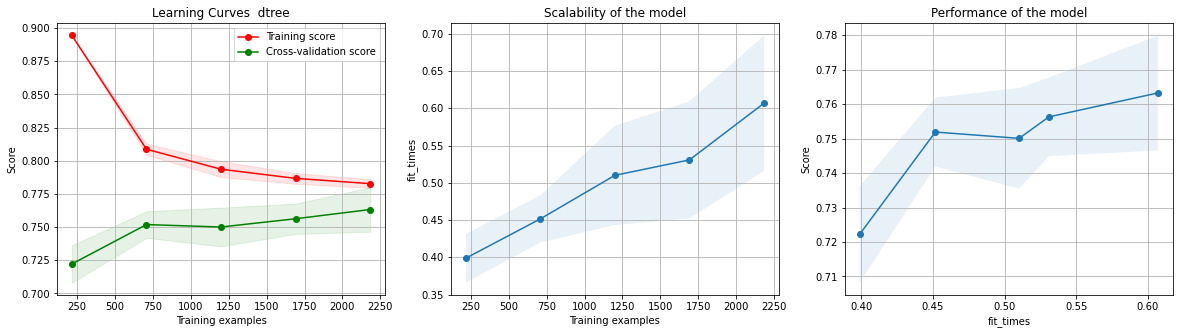

In [ ]:
plot_learning_curve(loaded_best_estimator_round2 , 
                    'Learning Curves  dtree',
                    X_train, y_train, n_jobs=-1)

### <font color = 'pickle'>**Check Cross Validation Score and Train Score**

In [ ]:
#let's check the train scores
print(loaded_best_estimator_round2.score(X_train,y_train))

#let's check the cross validation score
print(loaded_complete_grid_round2.best_score_)

0.7761084646390619
0.762925698155056


Max_leaf_nodes = 20 gives us the best results. Since we used gridserach to explore values between 16 and 30, we do not need to do any further tuning. The cross validation errors are also very similar to round2.

## Hyperparameter Tuning - Round 3


### <font color = 'pickle'>**Specify Param Grid**

In [ ]:
# now we create the grid with all the parameters that we would like to test.
param_grid_3 = {
    'rf__n_estimators' :np.arange(200,400, 20),
    'rf__max_features' : ["log2"],
    'rf__max_depth': [5],
    'rf__min_samples_leaf': [3],
    'rf__max_leaf_nodes': [20], 
    }

# now we set up the grid search with cross-validation
grid_rf_3 = GridSearchCV(churn_pipeline_rf, param_grid_3,
                           cv=5, return_train_score= True, n_jobs=-1)

### <font color = 'pickle'>**Fit Model**

In [ ]:
grid_rf_3.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('drop_features',
                                        DropFeatures(features_to_drop=['RowNumber',
                                                                       'CustomerId',
                                                                       'Surname',
                                                                       'Unnamed: '
                                                                       '0'])),
                                       ('imputer_median',
                                        MeanMedianImputer(variables=['Age',
                                                                     'Balance',
                                                                     'NumOfProducts'])),
                                       ('imputer_catgorical_frequent',
                                        CategoricalImputer(imputation_method='frequent',
                                                           variables=['Gender',
                                                                      'Geography'])),
                                       ('imputer_...
                                                      ignore_format=True,
                                                      variables=['Geography',
                                                                 'Gender',
                                                                 'HasCrCard',
                                                                 'IsActiveMember'])),
                                       ('rf',
                                        RandomForestClassifier(oob_score=True,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5], 'rf__max_features': ['log2'],
                         'rf__max_leaf_nodes': [20],
                         'rf__min_samples_leaf': [3],
                         'rf__n_estimators': array([200, 220, 240, 260, 280, 300, 320, 340, 360, 380])},
             return_train_score=True)

### <font color = 'pickle'>**Get Best Params**

In [ ]:
#Let's check the best_parameters from GridSearchCv for our model
print(grid_rf_3.best_params_)

{'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__max_leaf_nodes': 20, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 220}


### <font color = 'pickle'>**Save Model**

In [ ]:
file_best_estimator_round3 = save_model_folder / 'rf_round3_params.pkl'
file_complete_grid_round3 = save_model_folder / 'rf_round3_model.pkl'

In [ ]:
joblib.dump(grid_rf_3.best_estimator_, file_best_estimator_round3)
joblib.dump(grid_rf_3, file_complete_grid_round3)

['/home/harpreet/Insync/google_drive_shaannoor/data/models/ml_fall_2022/rf_round3_model.pkl']

### <font color = 'pickle'>**Load Saved Model**

In [ ]:
loaded_best_estimator_round3 = joblib.load(file_best_estimator_round3)
loaded_complete_grid_round3 = joblib.load(file_complete_grid_round3)

### <font color = 'pickle'>**Plot Learning Curve**

<module 'matplotlib.pyplot' from '/home/harpreet/mambaforge/lib/python3.9/site-packages/matplotlib/pyplot.py'>

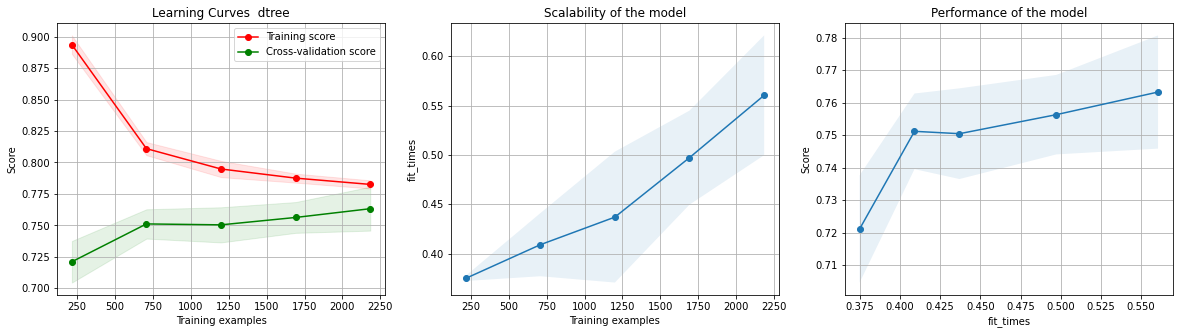

In [ ]:
plot_learning_curve(loaded_best_estimator_round3 , 
                    'Learning Curves  dtree',
                    X_train, y_train, n_jobs=-1)

### <font color = 'pickle'>**Check Cross Validation Score and Train Score**

In [ ]:
#let's check the train scores
print(loaded_best_estimator_round3.score(X_train,y_train))

#let's check the cross validation score
print(loaded_complete_grid_round3.best_score_)

0.7768413338219128
0.7629263702658198


# <font color = 'pickle'>**Perfromnace on Test Data**

### <font color = 'pickle'>**Load saved Model**

In [ ]:
file_best_estimator_rf = save_model_folder / 'rf_round3_params.pkl'
best_estimator_rf = joblib.load(file_best_estimator_rf)

### <font color = 'pickle'>**Test Accuracy**

In [ ]:
#let's check the test scores for final model
print(f'Test data accauracy for round 3: {best_estimator_rf .score(X_test,y_test)}')

Test data accauracy for round 3: 0.7710037174721189


### <font color = 'pickle'> **Confusion Matrix**

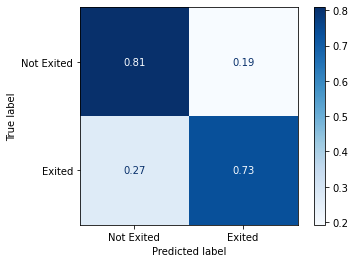

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_estimator_rf, X_test, y_test,
                                 display_labels=['Not Exited', 'Exited'],
                                 cmap=plt.cm.Blues,
                                 normalize = 'true')
plt.grid(False)
plt.show()

# Final Conclusion

The round 3 pipeline seems to have the best performance. The best model till now was logistic regression. The random forest gave slightly better perfrmance than logistic regression (cross validation score) **Hence we conclude that we should use Random Forest.**